## 서울특별시 시군구 지도 시각화 테스트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import geopandas as gpd

base_path = '/content/drive/MyDrive/git/프로젝트/ch07/data/'
seoul_gpd = gpd.read_file(base_path + "seoul_sig_cd_20241028.geojson", encoding='euc-kr')
seoul_gpd = seoul_gpd.loc[seoul_gpd['SIG_CD'].str.startswith('11')].reset_index(drop=True)

In [14]:
seoul_gpd = seoul_gpd.set_crs(epsg='5178', allow_override=True)
seoul_gpd.to_crs(epsg='4326').head()

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,占쏙옙占싸깍옙,"MULTIPOLYGON (((127.00648 37.58322, 127.00655 ..."
1,11140,Jung-gu,占쌩깍옙,"MULTIPOLYGON (((127.02098 37.57471, 127.0212 3..."
2,11170,Yongsan-gu,占쏙옙占쎄구,"MULTIPOLYGON (((126.96702 37.55841, 126.96701 ..."
3,11200,Seongdong-gu,占쏙옙占쏙옙占쏙옙,"MULTIPOLYGON (((127.04125 37.57509, 127.04308 ..."
4,11215,Gwangjin-gu,占쏙옙占쏙옙占쏙옙,"MULTIPOLYGON (((127.09951 37.57515, 127.10008 ..."


In [15]:
seoul_gpd['center_point'] = seoul_gpd['geometry'].geometry.centroid
seoul_gpd['geometry'] = seoul_gpd['geometry'].to_crs(epsg=4326)
seoul_gpd['center_point'] = seoul_gpd['center_point'].to_crs(epsg=4326)
seoul_gpd['경도'] = seoul_gpd['center_point'].map(lambda x: x.xy[0][0])
seoul_gpd['위도'] = seoul_gpd['center_point'].map(lambda x: x.xy[1][0])
seoul_gpd.head()

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry,center_point,경도,위도
0,11110,Jongno-gu,占쏙옙占싸깍옙,"MULTIPOLYGON (((127.00648 37.58322, 127.00655 ...",POINT (126.97516 37.59767),126.975159,37.597667
1,11140,Jung-gu,占쌩깍옙,"MULTIPOLYGON (((127.02098 37.57471, 127.0212 3...",POINT (126.99381 37.56289),126.993806,37.562893
2,11170,Yongsan-gu,占쏙옙占쎄구,"MULTIPOLYGON (((126.96702 37.55841, 126.96701 ...",POINT (126.97775 37.53413),126.977745,37.534135
3,11200,Seongdong-gu,占쏙옙占쏙옙占쏙옙,"MULTIPOLYGON (((127.04125 37.57509, 127.04308 ...",POINT (127.0389 37.55378),127.038898,37.553780
4,11215,Gwangjin-gu,占쏙옙占쏙옙占쏙옙,"MULTIPOLYGON (((127.09951 37.57515, 127.10008 ...",POINT (127.08359 37.54947),127.083585,37.549471


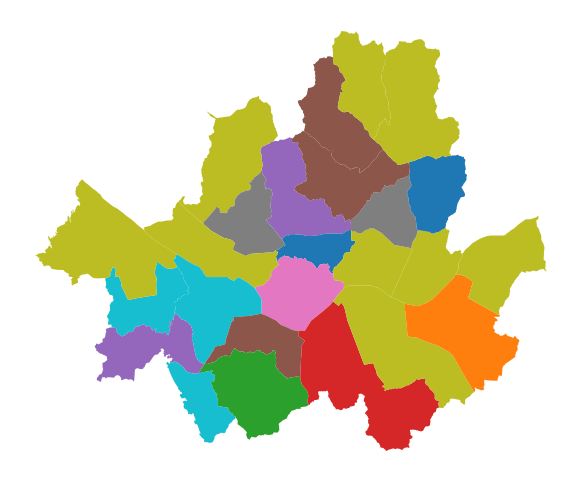

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
seoul_gpd.plot(column='SIG_KOR_NM', ax=ax)
plt.axis('off')
plt.show()

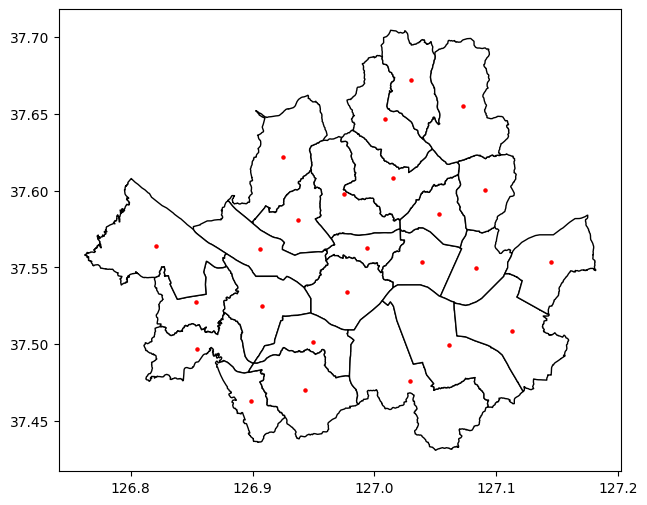

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
seoul_gpd.plot(ax=ax, color='white', edgecolor='black')
seoul_gpd['center_point'].plot(marker='o', color='red', markersize=5, ax=ax)
plt.show()

## 서울시 부동산 데이터와 병합

In [18]:
import pandas as pd
seoul = pd.read_csv(base_path  + "seoul_real_estate.csv", parse_dates=['DEAL_YMD'])
seoul['month'] = seoul['DEAL_YMD'].dt.month
seoul = seoul[(seoul['HOUSE_TYPE'] == '아파트') & (seoul['month'].isin([3, 4]))]
seoul = seoul[['DEAL_YMD', 'month', 'SGG_CD', 'SGG_NM', 'OBJ_AMT','HOUSE_TYPE']].reset_index(drop=True)
seoul.head()

,DEAL_YMD,month,SGG_CD,SGG_NM,OBJ_AMT,HOUSE_TYPE
0,2023-04-30,4,11290,성북구,72500,아파트
1,2023-04-30,4,11350,노원구,13500,아파트
2,2023-04-30,4,11440,마포구,143000,아파트
3,2023-04-30,4,11290,성북구,79800,아파트
4,2023-04-30,4,11215,광진구,142000,아파트


In [19]:
summary_df = seoul.groupby(['SGG_CD', 'month'])['OBJ_AMT'].agg(['mean','std', 'size']).reset_index()
summary_df.head(4)

,SGG_CD,month,mean,std,size
0,11110,3,134132.857143,71404.337903,21
1,11110,4,119094.117647,77102.549168,17
2,11140,3,92777.096774,55285.404294,31
3,11140,4,81534.067797,46662.298092,59


In [20]:
seoul_gpd.head(1)

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry,center_point,경도,위도
0,11110,Jongno-gu,占쏙옙占싸깍옙,"MULTIPOLYGON (((127.00648 37.58322, 127.00655 ...",POINT (126.97516 37.59767),126.975159,37.597667


In [21]:
summary_df = summary_df.rename(columns={"SGG_CD" : "SIG_CD"})
summary_df['SIG_CD'] = summary_df['SIG_CD'].astype(str)

In [22]:
summary_df.head(1)

,SIG_CD,month,mean,std,size
0,11110,3,134132.857143,71404.337903,21


In [23]:
merge_df = seoul_gpd.merge(summary_df, on = 'SIG_CD')
merge_df.head(1)

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry,center_point,경도,위도,month,mean,std,size
0,11110,Jongno-gu,占쏙옙占싸깍옙,"MULTIPOLYGON (((127.00648 37.58322, 127.00655 ...",POINT (126.97516 37.59767),126.975159,37.597667,3,134132.857143,71404.337903,21


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

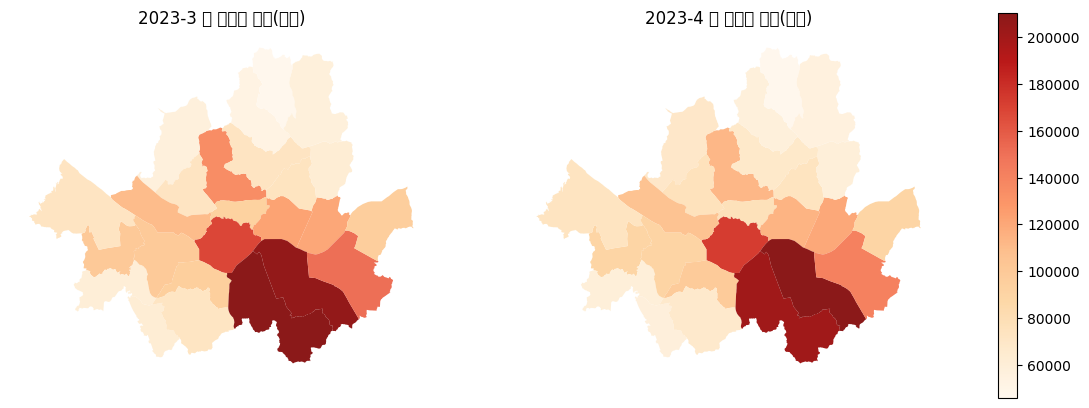

In [29]:
from matplotlib import font_manager, rc

# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,10))
merge_df[merge_df['month'] == 3].plot(ax=ax[0], column="mean", cmap="OrRd", legend=False, alpha=0.9)
merge_df[merge_df['month'] == 4].plot(ax=ax[1], column="mean", cmap="OrRd", legend=False, alpha=0.9)

patch_col = ax[0].collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.5)
ax[0].set_title('2023-3 월 아파트 평균(만원)')
ax[1].set_title('2023-4 월 아파트 평균(만원)')
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()

## seoul json 파일 생성하기

In [30]:
merge_df.head(1)

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry,center_point,경도,위도,month,mean,std,size
0,11110,Jongno-gu,占쏙옙占싸깍옙,"MULTIPOLYGON (((127.00648 37.58322, 127.00655 ...",POINT (126.97516 37.59767),126.975159,37.597667,3,134132.857143,71404.337903,21


In [36]:
import numpy as np
result = merge_df.explode(index_parts=True).reset_index(drop=True)
result.head(3)

# 멀티폴리곤을 폴리곤으로 변경

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,center_point,경도,위도,month,mean,std,size,geometry
0,11110,Jongno-gu,占쏙옙占싸깍옙,POINT (126.97516 37.59767),126.975159,37.597667,3,134132.857143,71404.337903,21,"POLYGON ((127.00648 37.58322, 127.00655 37.583..."
1,11110,Jongno-gu,占쏙옙占싸깍옙,POINT (126.97516 37.59767),126.975159,37.597667,4,119094.117647,77102.549168,17,"POLYGON ((127.00648 37.58322, 127.00655 37.583..."
2,11140,Jung-gu,占쌩깍옙,POINT (126.99381 37.56289),126.993806,37.562893,3,92777.096774,55285.404294,31,"POLYGON ((127.02098 37.57471, 127.0212 37.5746..."


In [37]:
month = 3
result = result[result['month']==month]
gdf = gpd.GeoDataFrame({
    "SIG_ENG_NM" : result['SIG_ENG_NM'],
    "geometry" : result['geometry']
})

gdf.to_file("./seoul.geojson", driver = "GeoJSON")

In [39]:
import json
import plotly.express as px

with open('./seoul.geojson', encoding='UTF-8') as f:
    data = json.load(f)

fig = px.choropleth_mapbox(result,
                           geojson=data,
                           locations='SIG_ENG_NM', color='mean',
                           color_continuous_scale="Viridis",
                           featureidkey = 'properties.SIG_ENG_NM',
                           mapbox_style="open-street-map",
                           zoom=9.5,
                           center = {"lat": 37.563383, "lon": 126.996039},
                           opacity=0.5,
                           labels={'mean':'아파트 평균가격(만원)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(hovertemplate='<b>%{location}</b><br>아파트평균가격: %{z:,.0f}(만원)')
fig.update_coloraxes(colorbar_tickformat='000')